An optional first step is to update the crashes data files.  Three have been provided, as of 2022-02, but if you require newer versions:

1. Register a personal TIMS account at https://tims.berkeley.edu/
2. Using the "SWITRS Query & Map" tool select the following parameters or similar:
  * Date: 2019-01-01 -> 2020-12-31
  * County: \<select any county\>
  * City: All
  * Crash Filters:
    * Motor Vehicle Involved with...
      * B - Pedestrian
      * G - Bicycle
3. Click "Show Results".
4. Click "Download Raw Data".
  * Save CSV file to the `TIMS` directory of this repository.
5. Repeat steps 1-5 for another county until you have enough counties

In [24]:
# First step is to extract all the relevant fields from the crash csv files.  Here we load multiple
# CSV files, assuming each represents a different county of the same state (California in this case).
# The CSV files are generated by querying TIMS using the aforementioned steps.
import pandas as pd

crashes_df = pd.concat(
    [
        pd.read_csv(
            csv_filename,
            usecols=[
                "CASE_ID",
                "COLLISION_DATE",
                "COLLISION_TIME",
                "DAY_OF_WEEK",
                "COLLISION_SEVERITY",
                "COUNTY",
                "CITY",
                "POINT_X",
                "POINT_Y",
            ],
            parse_dates=["COLLISION_DATE"],
            low_memory=False,
        )
        for csv_filename in [
            # Update this list with any additional CSV files you added.
            # At the time of writing, the following logic is designed to simply average
            # all the counties together, giving satewide results only.
            "TIMS/crashes_san_diego.csv",
            "TIMS/crashes_los_angeles.csv",
            "TIMS/crashes_san_francisco.csv",
        ]
    ],
    ignore_index=True
)

crashes_df.tail()

,CASE_ID,COLLISION_DATE,COLLISION_TIME,DAY_OF_WEEK,COLLISION_SEVERITY,COUNTY,CITY,POINT_X,POINT_Y
34159,9218637,2020-12-15,1637,2,3,SAN FRANCISCO,SAN FRANCISCO,-122.499100,37.755119
34160,9219287,2020-11-20,831,5,4,SAN FRANCISCO,SAN FRANCISCO,-122.389687,37.786221
34161,9222498,2020-12-17,1345,4,4,SAN FRANCISCO,SAN FRANCISCO,-122.408058,37.784000
34162,9242272,2020-08-22,1800,6,4,SAN FRANCISCO,SAN FRANCISCO,-122.418892,37.756813
34163,9242419,2020-12-14,1445,1,4,SAN FRANCISCO,SAN FRANCISCO,-122.431580,37.769321


In [25]:
import datetime
import numpy as np

# Identify crashes with severity 1, which means it resulted in the death of
# the pedestrian or cyclist.
crashes_df["fatal"] = crashes_df["COLLISION_SEVERITY"] == 1

# The TIMS database provides a crash time as a sequence of 4 digits with the format "HHMM".
# The hour and the minute is more useful to us in isolated form, so extract them here.
crashes_df["COLLISION_TIME"] = crashes_df["COLLISION_TIME"].astype(int)
crashes_df["collision_hour"] = (crashes_df["COLLISION_TIME"]/100).astype(int)
crashes_df["collision_minute"] = (crashes_df["COLLISION_TIME"]%100).astype(int)

# The hypothesis is mostly concerned with days on which streets were predictably
# congested with traffic due to peak commute times.  Therefore, it may be useful to
# evaluate weekends separately from weekdays.  So, the first step is to identify
# which crashes happen on weekends and which happen on weekdays.
crashes_df["dow_type"] = np.nan
crashes_df.loc[~(crashes_df["DAY_OF_WEEK"]).isin([6, 7]), "dow_type"] = "weekday"
crashes_df.loc[(crashes_df["DAY_OF_WEEK"]).isin([6, 7]), "dow_type"] = "weekend"

# Define a few critical dates.  I guessed these based on memory, so they're
# pretty approximate.
eval_start     = pd.to_datetime('2019-01-01') # Beginning of the evaluation period.
outbreak_start = pd.to_datetime('2020-03-01') # Start of the outbreak.
outbreak_end   = pd.to_datetime('2020-05-01') # End of the outbreak, for evaluation purposes.
eval_end       = pd.to_datetime('2021-01-01') # End of the evaluation period.

time_periods = {
    "pre_outbreak": {
        "start": eval_start,
        "end": outbreak_start,
    },
    "during_outbreak": {
        "start": outbreak_start,
        "end": outbreak_end,
    },
    "post_outbreak": {
        "start": outbreak_end,
        "end": eval_end,
    },
}
for time_period_key, time_period in time_periods.items():
    pretty_key = time_period_key.replace("_", " ").title()
    pretty_range = f'{time_period["start"].date()} through {time_period["end"].date()}'
    time_period["display_name"] = \
        f'{pretty_key} ({pretty_range})'
    
# Assign the time period key to each crash.
crashes_df["time_period_key"] = np.nan
for time_period_key, time_period in time_periods.items():
    crashes_df.loc[
        (
            (crashes_df["COLLISION_DATE"] >= time_period["start"]) &
            (crashes_df["COLLISION_DATE"] < time_period["end"])
        ),
        "time_period_key"
    ] = time_period_key

# Some crashes have the hour listed as 24 or 25.  This simply means the crash happened
# after midnight, and the date corresponds to the previous day.  So, in these cases we
# must shift the date and subtract 24 from the hour so that the dates are accurate and
# the hour is within standard 24h time.
crashes_df.loc[crashes_df["collision_hour"] > 23, "COLLISION_DATE"] = \
    crashes_df["COLLISION_DATE"] + pd.Timedelta(days=1)
crashes_df.loc[crashes_df["collision_hour"] > 23, "collision_hour"] = \
    crashes_df["collision_hour"] - 24

In [26]:
# Do the actual bucketing of crashes by hour.
crash_frequency_df = (
    crashes_df.groupby(["collision_hour", "fatal", "dow_type", "time_period_key"])["CASE_ID"]
              .count()
              .reset_index(name="collision_count")
)

# Calculate the number of days in each time period, and use that as the denominator to
# normalize the counts in each bucket.  The resulting collision_frequency column units are
# collisions-per-day.
def get_days_count(row):
    time_period = time_periods[row["time_period_key"]]
    total_days = (time_period["end"] - time_period["start"]).days
    dow_type_modifier = 5/7 if row["dow_type"] == "weekday" else 2/7
    return total_days * dow_type_modifier
crash_frequency_df["time_period_days_count"] = crash_frequency_df.apply(get_days_count, axis=1)
crash_frequency_df["collision_frequency"] = \
    crash_frequency_df.collision_count / crash_frequency_df.time_period_days_count

# Sample the table once more.
crash_frequency_df

,collision_hour,fatal,dow_type,time_period_key,collision_count,time_period_days_count,collision_frequency
0,0,False,weekday,during_outbreak,11,43.571429,0.252459
1,0,False,weekday,post_outbreak,38,175.000000,0.217143
2,0,False,weekday,pre_outbreak,113,303.571429,0.372235
3,0,False,weekend,during_outbreak,4,17.428571,0.229508
4,0,False,weekend,post_outbreak,27,70.000000,0.385714
...,...,...,...,...,...,...,...
258,23,True,weekday,post_outbreak,10,175.000000,0.057143
259,23,True,weekday,pre_outbreak,20,303.571429,0.065882
260,23,True,weekend,during_outbreak,3,17.428571,0.172131
261,23,True,weekend,post_outbreak,3,70.000000,0.042857


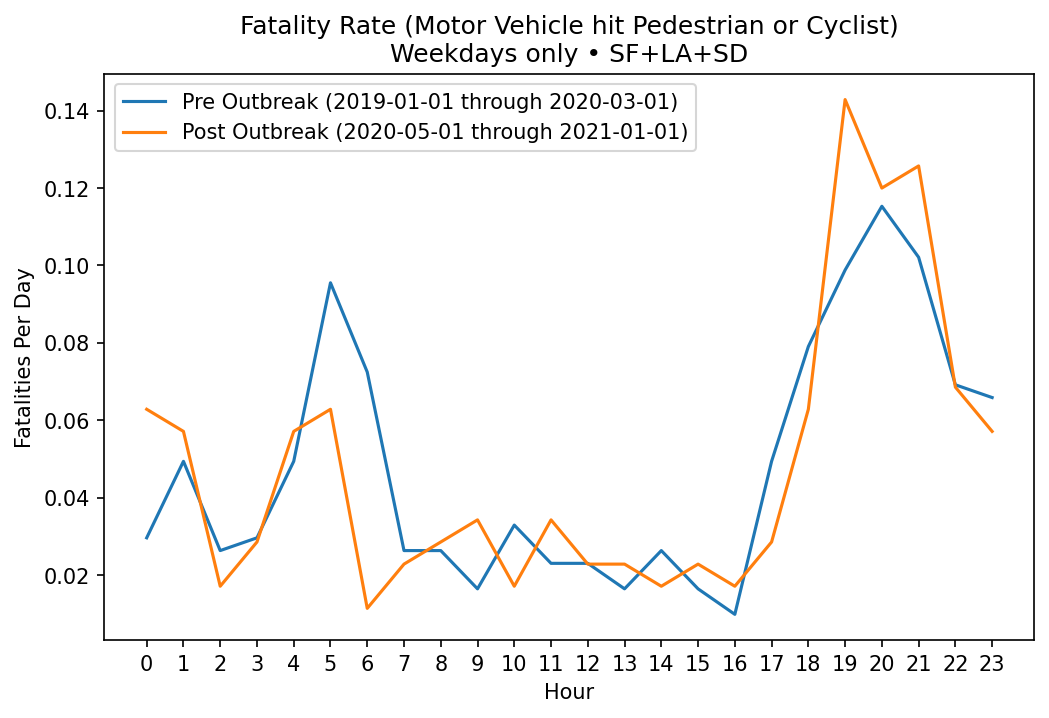

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot pre-pandemic crashes vs. hour
ax.plot(
    crash_frequency_df[
            (crash_frequency_df.fatal) &
            (crash_frequency_df.dow_type == "weekday") &
            (crash_frequency_df.time_period_key == "pre_outbreak")
    ].set_index("collision_hour").collision_frequency,
    label=time_periods["pre_outbreak"]["display_name"],
)

# Plot post-pandemic crashes vs. hour
ax.plot(
    crash_frequency_df[
            (crash_frequency_df.fatal) &
            (crash_frequency_df.dow_type == "weekday") &
            (crash_frequency_df.time_period_key == "post_outbreak")
    ].set_index("collision_hour").collision_frequency,
    label=time_periods["post_outbreak"]["display_name"],
)

plt.title("Fatality Rate (Motor Vehicle hit Pedestrian or Cyclist)\nWeekdays only • SF+LA+SD")
plt.ylabel('Fatalities Per Day') 
plt.xlabel('Hour') 
ax.set_xticks(range(0, 24))
legend = ax.legend(loc='upper left')
fig.set_figwidth(8)
fig.set_figheight(5)
fig.set_dpi(150.0)

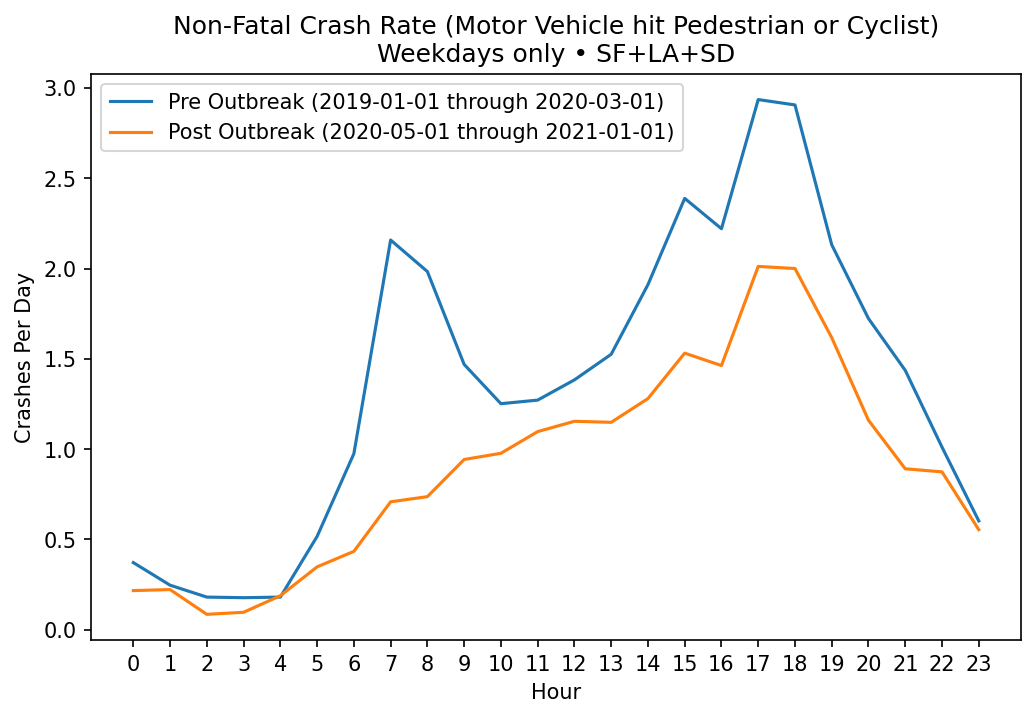

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot pre-pandemic crashes vs. hour
ax.plot(
    crash_frequency_df[
            (~crash_frequency_df.fatal) &
            (crash_frequency_df.dow_type == "weekday") &
            (crash_frequency_df.time_period_key == "pre_outbreak")
    ].set_index("collision_hour").collision_frequency,
    label=time_periods["pre_outbreak"]["display_name"],
)

# Plot post-pandemic crashes vs. hour
ax.plot(
    crash_frequency_df[
            (~crash_frequency_df.fatal) &
            (crash_frequency_df.dow_type == "weekday") &
            (crash_frequency_df.time_period_key == "post_outbreak")
    ].set_index("collision_hour").collision_frequency,
    label=time_periods["post_outbreak"]["display_name"],
)

plt.title("Non-Fatal Crash Rate (Motor Vehicle hit Pedestrian or Cyclist)\nWeekdays only • SF+LA+SD")
plt.ylabel('Crashes Per Day') 
plt.xlabel('Hour') 
ax.set_xticks(range(0, 24))
legend = ax.legend(loc='upper left')
fig.set_figwidth(8)
fig.set_figheight(5)
fig.set_dpi(150.0)